# ap selection

## data preparation

In [98]:
import os
import sys
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

def smoothen(data, column, span = 5):
    fwd = data[column].ewm(span = span).mean()
    bwd = data[column][::-1].ewm(span = span).mean()
    filtered = np.vstack(( fwd, bwd[::-1] ))
    data[column] = np.mean(filtered, axis = 0)

def annotate_best(data, nodes = ['m1', 'w1', 'w2', 'w3']):
    data['best'] = data[nodes].idxmax(axis = 1)
    data['bestVal'] = data[nodes].max(axis = 1)
    
def aggregate_node_data(metric = 'tghptConsumer', nodes = ['m1', 'w4', 'tp-03']):
    aggr_data = pd.DataFrame(columns = ['systime'])
    for node in nodes:
        node_data = pd.read_csv(os.path.join(data_dir, ('%s/basic.bitrates.processed.csv' % (node))))
        node_data[node] = node_data[metric]
        aggr_data = pd.merge(aggr_data, node_data[['tmstmp-custom', node]], on = ['tmstmp-custom'], how = 'outer')
        
    aggr_data.sort_values(by = ['systime'], inplace = True)
    aggr_data.drop_duplicates(subset = ['systime'], inplace = True)
    aggr_data.dropna(subset = nodes, inplace = True)
    
    return aggr_data.reset_index(drop = True)


## ap selection : ml approach

1. for every data row, predict bitrate of each ap
2. smoothen each ap's bitrate
3. use the highest bitrate as the 'best'
4. compare throughput w/ the scripted handoff approach

### 1 : load data

In [73]:
import warnings
import pandas as pd
import sys
import numpy as np

warnings.filterwarnings('ignore')

base_filename = "/Volumes/data/vehicular-traces-gaia/final-exp-log.csv"
dataset = pd.read_csv(base_filename)
dataset = dataset.reset_index(drop = True)
# dataset = dataset[dataset['traceNr'].isin(['301', '302', '303', '304'])].reset_index(drop = True)

In [59]:
print(list(dataset.columns))

['systime', 'traceNr', 'lon', 'lat', 'receiverAlt', 'receiverX', 'receiverY', 'receiverDist', 'receiverSpeed', 'receiverId', 'senderId', 'isIperfOn', 'isInLap', 'rssiMean', 'channelFreq', 'channelBw', 'channelUtil', 'dataRateMedian', 'dataRateMean', 'nBytesReceived', 'tghptConsumer', 'wifiType', 'nrClients', 'nRetries', 'meanBeaconRssi', 'meanInterBeaconTime', 'nBeacons']


### 2 : feature filtering

In [74]:
features = list(dataset.columns)
# filter out features w/ no variability
features = [x for x in features if len(dataset[x].unique()) > 1]
# filter out pre-defined columns
to_drop = ['systime', 'isInLap', 'senderId', 'receiverId', 'isIperfOn', 'wifiType', 'nrClients', 'nBytesReceived', 'dataRateMean', ]
features = [x for x in features if x not in to_drop]

filtered_data = dataset.dropna(subset = features)
filtered_data = filtered_data.dropna(axis = 1, how = 'any')
features = sorted(list(set(features) & set(filtered_data.columns)))
print(len(filtered_data))

46566


### 3 : balance dataset

In [99]:
from sklearn.utils import resample

selected_bitrates = [br for br in set(filtered_data['dataRateMedian'].values) if len(filtered_data[filtered_data['dataRateMedian'] == br]['dataRateMedian']) > 300]
class_sizes = [len(filtered_data[filtered_data['dataRateMedian'] == br]['dataRateMedian']) for br in selected_bitrates]
n_samples = min(class_sizes)

balanced_data = pd.DataFrame()
for br in selected_bitrates:
    df = resample(filtered_data[filtered_data['dataRateMedian'] == br], 
        replace = False,           # sample without replacement
        n_samples = n_samples,     # to match minority class
        random_state = 123)        # reproducible results
    balanced_data = pd.concat([balanced_data, df], ignore_index = True)
    
balanced_data = balanced_data.reset_index(drop = True)

print(len(balanced_data))
print('nr. of classes : %d' % (len(selected_bitrates)))
print(balanced_data[['dataRateMedian']].groupby(['dataRateMedian']).size().reset_index(name = 'size', drop = False))

9510
nr. of classes : 30
    dataRateMedian  size
0           0.0000   317
1           6.5000   317
2          13.0000   317
3          14.4444   317
4          19.5000   317
5          21.6667   317
6          26.0000   317
7          27.0000   317
8          28.8889   317
9          39.0000   317
10         43.3333   317
11         52.0000   317
12         54.0000   317
13         57.7778   317
14         58.5000   317
15         65.0000   317
16         72.2222   317
17         81.0000   317
18         86.6667   317
19        108.0000   317
20        162.0000   317
21        216.0000   317
22        243.0000   317
23        300.0000   317
24        360.0000   317
25        385.0000   317
26        400.0000   317
27        770.0000   317
28        962.5000   317
29       2310.0000   317


In [69]:
print(balanced_data[['systime', 'receiverId', 'meanBeaconRssi']].sort_values(by = ['systime']).reset_index(drop = True))

           systime receiverId  meanBeaconRssi
0     1.566297e+09         w4          -100.0
1     1.566297e+09         w4          -100.0
2     1.566297e+09         w4          -100.0
3     1.566297e+09         w4          -100.0
4     1.566297e+09         w4          -100.0
...            ...        ...             ...
5847  1.566307e+09      tp-03          -100.0
5848  1.566307e+09      tp-03          -100.0
5849  1.566307e+09         m1          -100.0
5850  1.566307e+09         w4          -100.0
5851  1.566307e+09      tp-03          -100.0

[5852 rows x 3 columns]


### 4 : train & test random forest classifier

train data size : 0.795435, test data size : 0.204565, train traces : [404, 303, 302, 401, 403, 402]
-----
['channelBw', 'channelFreq', 'channelUtil', 'lat', 'lon', 'meanBeaconRssi', 'meanInterBeaconTime', 'nBeacons', 'nRetries', 'receiverAlt', 'receiverDist', 'receiverSpeed', 'receiverX', 'receiverY']
traces in training data : {302, 303, 401, 402, 403, 404}
traces in test data : {304, 405}
accuracy : random forest (w/ location info) : 0.3687566418703507)
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       130
           6       0.41      0.65      0.50        54
          13       0.31      0.46      0.37        59
          14       0.38      0.18      0.25        77
          26       0.33      0.18      0.24        60
          27       0.22      1.00      0.36        18
          28       0.22      0.23      0.22        47
          39       0.24      0.26      0.25        77
          43       0.31      0.33      0.32        81

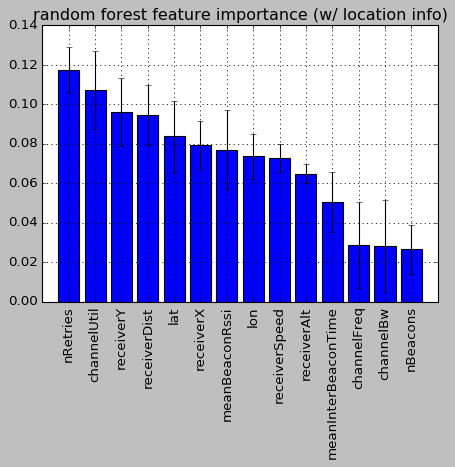

train data size : 0.704130, test data size : 0.295870, train traces : [401, 405, 403, 404, 303, 402]
-----
['channelBw', 'channelFreq', 'channelUtil', 'lat', 'lon', 'meanBeaconRssi', 'meanInterBeaconTime', 'nBeacons', 'nRetries', 'receiverAlt', 'receiverDist', 'receiverSpeed', 'receiverX', 'receiverY']
traces in training data : {303, 401, 402, 403, 404, 405}
traces in test data : {304, 302}
accuracy : random forest (w/ location info) : 0.41734019103600295)
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       166
           6       0.69      0.55      0.61       236
          13       0.32      0.41      0.36       155
          14       0.34      0.30      0.32       181
          26       0.43      0.28      0.34       133
          27       0.68      0.81      0.74       113
          28       0.32      0.49      0.39       113
          39       0.26      0.21      0.23       115
          43       0.28      0.23      0.25       14

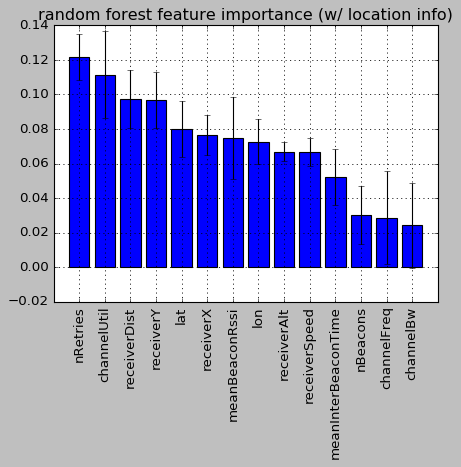

train data size : 0.729674, test data size : 0.270326, train traces : [405, 401, 404, 303, 302]
-----
['channelBw', 'channelFreq', 'channelUtil', 'lat', 'lon', 'meanBeaconRssi', 'meanInterBeaconTime', 'nBeacons', 'nRetries', 'receiverAlt', 'receiverDist', 'receiverSpeed', 'receiverX', 'receiverY']
traces in training data : {302, 303, 401, 404, 405}
traces in test data : {304, 402, 403}
accuracy : random forest (w/ location info) : 0.44310414153598715)
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       149
           6       0.46      0.67      0.55        48
          13       0.30      0.50      0.37        68
          14       0.37      0.20      0.26        96
          26       0.26      0.30      0.28        89
          27       0.57      0.88      0.69        80
          28       0.31      0.29      0.30        99
          39       0.34      0.21      0.26       122
          43       0.32      0.38      0.35       114
   

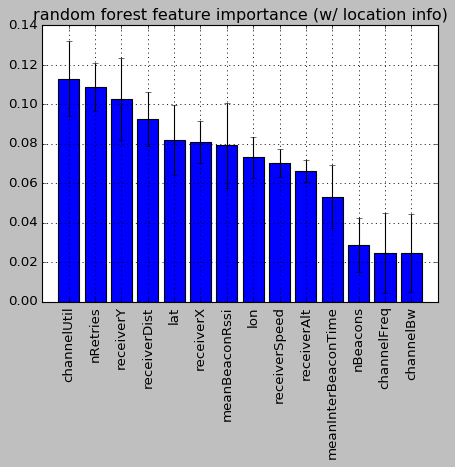

train data size : 0.883587, test data size : 0.116413, train traces : [405, 403, 302, 402, 404, 304, 303]
-----
['channelBw', 'channelFreq', 'channelUtil', 'lat', 'lon', 'meanBeaconRssi', 'meanInterBeaconTime', 'nBeacons', 'nRetries', 'receiverAlt', 'receiverDist', 'receiverSpeed', 'receiverX', 'receiverY']
traces in training data : {302, 303, 304, 402, 403, 404, 405}
traces in test data : {401}
accuracy : random forest (w/ location info) : 0.42483660130718953)
              precision    recall  f1-score   support

           0       0.68      0.75      0.71        20
           6       0.33      0.75      0.46         4
          13       0.56      0.50      0.53        20
          14       0.35      0.44      0.39        18
          26       0.37      0.39      0.38        36
          27       0.49      0.74      0.59        46
          28       0.28      0.34      0.31        44
          39       0.26      0.40      0.32        35
          43       0.20      0.22      0.21    

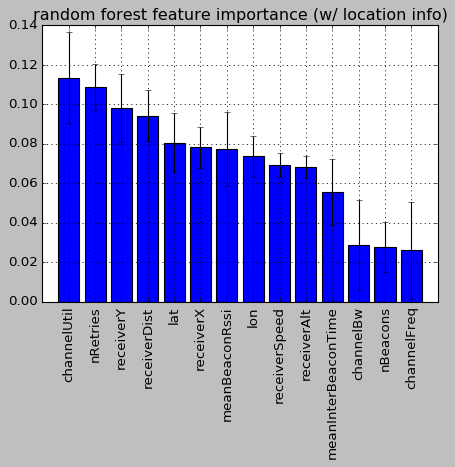

train data size : 0.748152, test data size : 0.251848, train traces : [402, 304, 404, 405, 302, 401]
-----
['channelBw', 'channelFreq', 'channelUtil', 'lat', 'lon', 'meanBeaconRssi', 'meanInterBeaconTime', 'nBeacons', 'nRetries', 'receiverAlt', 'receiverDist', 'receiverSpeed', 'receiverX', 'receiverY']
traces in training data : {302, 304, 401, 402, 404, 405}
traces in test data : {403, 303}
accuracy : random forest (w/ location info) : 0.4169184290030212)
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        82
           6       0.52      0.72      0.60       118
          13       0.37      0.22      0.27       144
          14       0.20      0.22      0.21       122
          26       0.42      0.57      0.48       108
          27       0.58      0.74      0.65       117
          28       0.38      0.17      0.23       119
          39       0.32      0.38      0.35        91
          43       0.35      0.26      0.30       101

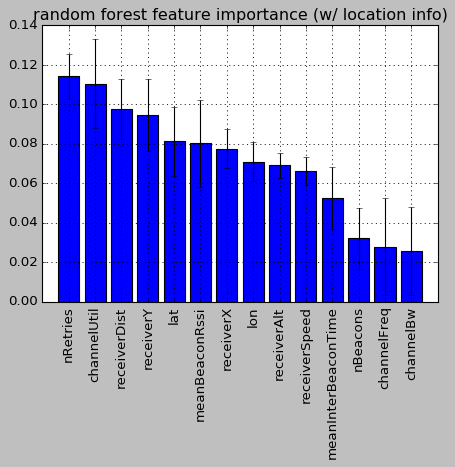

In [93]:
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def plot_feature_importance(x, forest, features, subtitle = ''):
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(forest.feature_importances_)[::-1]

    plt.style.use('classic')
    fig = plt.figure(figsize = (6.0, 6.0))
    ax = fig.add_subplot(1, 1, 1)
    ax.xaxis.grid(True, ls = 'dotted', lw = 0.75)
    ax.yaxis.grid(True, ls = 'dotted', lw = 0.75)
    ax.set_title("random forest feature importance (%s)" % (subtitle))
    ax.bar(range(x.shape[1]), forest.feature_importances_[indices],
            yerr = std[indices], align = "center")
        
    ax.set_xticks(range(x.shape[1]))
    ax.set_xticklabels([features[i] for i in indices], rotation = 90)
    ax.set_xlim([-1, x.shape[1]])
#     ax.set_ylim([0, 0.5])
    fig.tight_layout()
    plt.show()

def eval_clf_perf(clssfr_name, y_test, y_pred):
    print('accuracy : %s : %s)' % (clssfr_name, accuracy_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred))

def custom_train_test_split(x, y, mask):
    return x[mask], y[mask], x[~mask], y[~mask]
    
target_var = 'dataRateMedian'
to_drop = to_drop + ['dataRateMedian', 'receiverId', 'systime', 'tghptConsumer']
loc_dep = ['receiverDist', 'receiverX', 'receiverY', 'receiverAlt', 'receiverSpeed']

# cycle through different trace partitions, guaranteeing at least 70% of the data on the training partition
balanced_data['traceNr'] = balanced_data['traceNr'].astype(int)
balanced_data['dataRateMedian'] = balanced_data['dataRateMedian'].astype(int)
traces = list(balanced_data['traceNr'].unique())
for i in np.arange(0, 5, 1):
    
    train_size = 0.0
    remaining_traces = [t for t in traces]
    train_traces = []
    
    while ((train_size / float(len(balanced_data))) < .7):
        m = remaining_traces.pop(random.randrange(len(remaining_traces)))
        train_size += float(len(balanced_data[balanced_data['traceNr'] == m]))
        train_traces.append(m)
        
    train_perc = train_size / float(len(balanced_data))
    print('train data size : %f, test data size : %f, train traces : %s' % (train_perc, 1.0 - train_perc, train_traces))
    print('-----')
    
    f = [x for x in features if x not in to_drop + ['traceNr']]
    print(f)
    train_data = balanced_data[balanced_data['traceNr'].isin(train_traces)]
    test_data  = balanced_data[~balanced_data['traceNr'].isin(train_traces)]
    
    print('traces in training data : %s' % (set(train_data['traceNr'])))
    print('traces in test data : %s' % (set(test_data['traceNr'])))
    
    x_train = train_data[f]
    y_train = train_data[target_var]
    x_test  = test_data[f]
    y_test  = test_data[target_var]
    
    clssfr = RandomForestClassifier(n_estimators = 100, random_state = 1)
    clssfr.fit(x_train, y_train)
    y_pred = clssfr.predict(x_test)

    eval_clf_perf(('random forest (%s)' % ('w/ location info')), y_test, y_pred)
    plot_feature_importance(x_train + x_test, clssfr, f, subtitle = 'w/ location info')


### 5 : use bitrate prediction to pick best ap

In [94]:
pred_data = balanced_data[balanced_data['traceNr'].isin(set(test_data['traceNr']))]
pred_data['dataRatePred'] = y_pred

aggr_data = pd.DataFrame()
aggr_data['systime'] = pred_data['systime'].unique()
for node in ['m1', 'w4', 'tp-03']:
    node_data = pred_data[pred_data['receiverId'] == node][['systime', 'dataRatePred', 'tghptConsumer']]
    node_data[node] = node_data['dataRatePred']
    node_data[('%sThghpt') % (node)] = node_data['tghptConsumer']
    aggr_data = pd.merge(aggr_data, node_data[['systime', node, ('%sThghpt') % (node)]], on = ['systime'], how = 'left')
    
aggr_data.drop_duplicates(subset = ['systime'], inplace = True)
aggr_data.fillna(value = 0.0, inplace = True)
annotate_best(aggr_data, nodes = ['m1', 'w4', 'tp-03'])
aggr_data = aggr_data.reset_index(drop = True)

aggr_data['bestThghpt'] = aggr_data['best'].apply(lambda x : ('%sThghpt' % (x)))
i = pd.Series(list(aggr_data['bestThghpt'].values))
aggr_data['bestThghptVal'] = aggr_data.lookup(i.index, i.values)
aggr_data = aggr_data.sort_values(by = ['systime']).reset_index(drop = True)

# print(aggr_data)

### 6 : optimal ap choice

In [95]:
opt_data = pd.DataFrame()
opt_data['systime'] = pred_data['systime'].unique()
for node in ['m1', 'w4', 'tp-03']:
    node_data = pred_data[pred_data['receiverId'] == node][['systime', 'dataRateMedian', 'tghptConsumer']]
    node_data[node] = node_data['tghptConsumer']
    node_data[('%sThghpt') % (node)] = node_data['tghptConsumer']
    opt_data = pd.merge(opt_data, node_data[['systime', node, ('%sThghpt') % (node)]], on = ['systime'], how = 'left')
    
opt_data.drop_duplicates(subset = ['systime'], inplace = True)
opt_data.fillna(value = 0.0, inplace = True)
annotate_best(opt_data, nodes = ['m1', 'w4', 'tp-03'])
opt_data = opt_data.reset_index(drop = True)

opt_data['bestThghpt'] = opt_data['best'].apply(lambda x : ('%sThghpt' % (x)))
i = pd.Series(list(opt_data['bestThghpt'].values))
opt_data['bestThghptVal'] = opt_data.lookup(i.index, i.values)
opt_data = opt_data.sort_values(by = ['systime']).reset_index(drop = True)

# print(opt_data)

### 7 : best mean rssi

In [91]:
rssi_data = pd.DataFrame()
rssi_data['systime'] = pred_data['systime'].unique()
for node in ['m1', 'w4']:
    node_data = pred_data[pred_data['receiverId'] == node][['systime', 'rssiMean', 'tghptConsumer']]
    node_data[node] = node_data['rssiMean']
    node_data[('%sThghpt') % (node)] = node_data['tghptConsumer']
    rssi_data = pd.merge(rssi_data, node_data[['systime', node, ('%sThghpt') % (node)]], on = ['systime'], how = 'left')
    
rssi_data.drop_duplicates(subset = ['systime'], inplace = True)
for node in ['m1', 'w4']:
    rssi_data[('%sThghpt' % (node))].fillna(value = 0.0, inplace = True)
    rssi_data[('%s' % (node))].fillna(value = -100.0, inplace = True)
    
annotate_best(rssi_data, nodes = ['m1', 'w4'])
rssi_data = rssi_data.reset_index(drop = True)

rssi_data['bestThghpt'] = rssi_data['best'].apply(lambda x : ('%sThghpt' % (x)))
i = pd.Series(list(rssi_data['bestThghpt'].values))
rssi_data['bestThghptVal'] = rssi_data.lookup(i.index, i.values)
rssi_data = rssi_data.sort_values(by = ['systime']).reset_index(drop = True)

# print(rssi_data)

### 8 : compare throughput

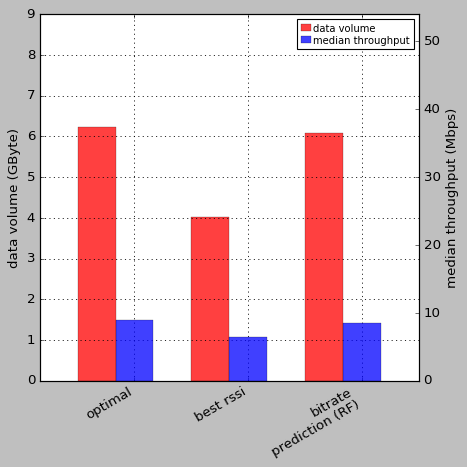

In [100]:
def compare_ap_selection(methods):
    
    plt.style.use('classic')
    fig = plt.figure(figsize = (6.0, 6.0))
    ax = fig.add_subplot(1, 1, 1)
    ax.xaxis.grid(True, ls = 'dotted', lw = 0.75)
    ax.yaxis.grid(True, ls = 'dotted', lw = 0.75)
    ax2 = ax.twinx()

    xx = 0.0
    xticks = []
    xtickslabels = []
    barwidth = 0.5
    interspace = 3.0 * barwidth
    intraspace = 1.0 * barwidth
    
    label = ['data volume', 'median throughput']
    
    for i, m in enumerate(methods.keys()):
        
        data = methods[m]['data']
        ax.bar(xx - barwidth,
            ((data['bestThghptVal'] / (8.0 * 1000.0))).sum(),
            width = barwidth, linewidth = 0.250, alpha = .75, 
            color = 'red', label = label[0])
        
        ax2.bar(xx,
            (data['bestThghptVal']).median(),
            width = barwidth, linewidth = 0.250, alpha = .75, 
            color = 'blue', label = label[1])

        ax.bar(np.nan, np.nan, label = label[1], linewidth = 0.250, alpha = .75, color = 'blue')
        label[0] = ''
        label[1] = ''

        xticks.append(xx)
        xtickslabels.append(methods[m]['x-ticklabel'])
        if i < (len(methods.keys()) - 1):
            xx += interspace

    ax.legend(
        fontsize = 9, 
        ncol = 1, loc = 'upper right',
        handletextpad = 0.2, handlelength = 1.0, labelspacing = 0.2, columnspacing = 0.5)

    # x-axis
    ax.set_xlim(-1.25, xx + (1.5 * barwidth))
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtickslabels, rotation = 30, ha = 'right')
    # y-axis
    #   - data volume
    ax.set_ylabel('data volume (GByte)')
    # so that legend doesn't overlap w/ bars
    ax.set_ylim(0.0, np.ceil(ax.get_ylim()[1] * 1.25))
    #   - median throughput
    k = float(len(ax.get_yticks()) - 1)
    d = ax2.get_yticks()[1] - ax2.get_yticks()[0]
    ax2.set_ylim(0.0, (3.0 * k) * d)
    ax2.set_ylabel('median throughput (Mbps)')
        
    fig.tight_layout()
    plt.show()

compare_ap_selection(methods = {
    'optimal' : {
        'data' : opt_data,
        'x-ticklabel' : 'optimal'
    },
    'rssi' : {
        'data' : rssi_data,
        'x-ticklabel' : 'best rssi'
    },
    'random forest' : {
        'data' : aggr_data,
        'x-ticklabel' : 'bitrate\nprediction (RF)'
    }
})

* When should we choose 802.11ad? It's hard to do it based on RSSI, since beacons are highly directional, and SNR hash a different domain of values (thus, probably a different meaning) than in 802.11n and 802.11ac